<a href="https://colab.research.google.com/github/naman3010/Natural-language-processing/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PGPM Term 5 — NLP Take-Home Assignment

**Title:** Sentiment Analysis on Financial News Headlines (BOW & TF-IDF + RandomForest)

**Objective:**  
This notebook implements a leakage-free NLP pipeline for sentiment classification on the All_News dataset (financial headlines). Steps:
- Load raw data
- Split data (train / test) before any fitting or leakage-prone operations
- Clean text (remove unwanted characters, URLs, HTML; lowercase; stopwords; acronym expansion; exhaustive per-token spellcheck using `pyspellchecker`)
- Vectorize with Bag-of-Words (CountVectorizer) and TF-IDF
- Train RandomForest classifiers independently on both representations
- Compare and report class-level metrics
- Save models and artifacts for reproducibility

**Data source:** Kaggle — https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news/data



In [12]:
#  install required libraries.

!pip install -q nltk scikit-learn pandas matplotlib seaborn textblob autocorrect openpyxl pyspellchecker


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 90.3 MB/s eta 0:00:00


In [13]:
#  Import libraries and print versions
import sys
import pandas as pd
import numpy as np
import sklearn
import nltk
import joblib
from spellchecker import SpellChecker
from tqdm import tqdm
import pkg_resources

# Print versions so we know the environment
print("python:", sys.version.splitlines()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("nltk:", nltk.__version__)
print("pyspellchecker:", pkg_resources.get_distribution("pyspellchecker").version)
print("tqdm:", pkg_resources.get_distribution("tqdm").version)
print("joblib:", joblib.__version__)


/tmp/ipython-input-1397491067.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1
nltk: 3.9.1
pyspellchecker: 0.8.3
tqdm: 4.67.1
joblib: 1.5.2


In [14]:
#  NLTK downloads
import nltk
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)


True

**Load dataset into a DataFrame (no header)**
 1. Attempts to load the dataset using a list of safe encodings.
 2. Renames the first two columns to 'Sentiment' and 'News Headline' (dataset has no header).



In [15]:
#  Load the dataset (no header). Try safe encodings.

dataset_path = "/content/all-data.csv"

encodings_to_try = ["utf-8", "latin1", "ISO-8859-1", "cp1252"]
loaded = False
for enc in encodings_to_try:
    try:
        print("Trying encoding:", enc)
        df = pd.read_csv(dataset_path, header=None, encoding=enc, engine="python")
        print("Loaded with", enc)
        loaded = True
        break
    except Exception as e:
        print("Failed with", enc, "->", e)

if not loaded:
    raise RuntimeError("Failed to load dataset. Check dataset_path and file format.")

# dataset has no header.
if df.shape[1] >= 2:
    df = df.rename(columns={df.columns[0]: "Sentiment", df.columns[1]: "News Headline"})
else:
    raise ValueError("DataFrame does not have at least 2 columns. Inspect the file.")

print("Data shape:", df.shape)
print("Sample rows:")
display(df.head(6))


Trying encoding: utf-8
Failed with utf-8 -> 'utf-8' codec can't decode byte 0xc6 in position 2582: invalid continuation byte
Trying encoding: latin1
Loaded with latin1
Data shape: (4846, 2)
Sample rows:


,Sentiment,News Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


 **Quick data checks and label mapping**

1. Shows null counts, unique sentiment labels, and basic distribution.
2. Maps textual sentiments to integer labels (negative=0, neutral=1, positive=2).
3. Filters out unexpected labels if any.


In [16]:
#  Quick dataset check and label mapping
# show nulls, value counts, and ensure labels are valid
print("Null counts per column:")
print(df.isnull().sum())

print("\nUnique sentiment values:")
print(df['Sentiment'].unique())


label_map = {"negative": 0, "neutral": 1, "positive": 2}
if not set(df['Sentiment'].unique()).issubset(set(label_map.keys())):
    print("Warning: unexpected sentiment labels found. Here are the unique labels:")
    print(df['Sentiment'].unique())
else:
    df = df[df['Sentiment'].isin(label_map.keys())].copy()
    df['label'] = df['Sentiment'].map(label_map)
    print("Label distribution:")
    print(df['Sentiment'].value_counts())


Null counts per column:
Sentiment        0
News Headline    0
dtype: int64

Unique sentiment values:
['neutral' 'negative' 'positive']
Label distribution:
Sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [17]:
# Train/test split on RAW text

from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X = df['News Headline']
y = df['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", len(X_train_raw), "Test size:", len(X_test_raw))


Train size: 3876 Test size: 970


**Define preprocessing utilities and main preprocessing function**

1. Defines robust helpers: URL removal, HTML removal, non-alphanumeric removal, acronym expansion.
2. Defines token-level spelling correction using pyspellchecker (every token is checked).
3. Defines the main `preprocess_text` function which runs the full pipeline for a single string.
4. The function accepts a flag `run_spellcheck` so you can toggle exhaustive checking.


In [18]:


import re
import pandas as pd
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize heavy components once
spell_checker = SpellChecker()                     # pyspellchecker (token-by-token)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Preserve important negation words for sentiment
for w in ("not", "no", "nor"):
    stop_words.discard(w)

# Finance-specific acronym expansion (extend as needed)
ACRONYM_EXPANSIONS = {
    "mkt": "market",
    "ipo": "initial public offering",
    "govt": "government",
    "yoy": "year over year",
    "qoq": "quarter over quarter",
    "usd": "us dollar",
    "bps": "basis points",
}

# helper to remove URLs
def remove_urls(text: str) -> str:
    if not text:
        return ""
    return re.sub(r"https?://\S+|www\.\S+", " ", text)

# helper to remove HTML tags and unescape
def remove_html_tags(text: str) -> str:
    if not text:
        return ""
    return re.sub(r"<.*?>", " ", text)

# helper to remove non-alphanumeric characters
def remove_non_alphanumeric(text: str) -> str:
    if not text:
        return ""
    return re.sub(r"[^A-Za-z0-9\s]", " ", text)

# helper to expand acronyms/tokens from the dictionary
def expand_acronyms(text: str) -> str:
    if not text:
        return ""
    tokens = text.split()
    expanded = [ACRONYM_EXPANSIONS.get(t, t) for t in tokens]
    return " ".join(expanded)


def correct_token_spelling(token: str) -> str:
    """
    Correct a single token using pyspellchecker.
    - keep numeric tokens unchanged
    - keep single-character tokens unchanged
    - return original token if correction fails
    """
    if token is None:
        return ""
    token = str(token)
    if token == "":
        return ""

    if token.isnumeric():
        return token
    if len(token) <= 1:
        return token
    try:
        corrected = spell_checker.correction(token)
    except Exception:
        corrected = token
    if corrected is None:
        return token
    return str(corrected)


def correct_text_spelling_full(text: str) -> str:
    """
    Token-by-token spelling correction across the entire text using pyspellchecker.
    This checks every token and is intentionally thorough and slow.
    """
    if text is None:
        return ""
    text = str(text)
    corrected_tokens = []
    for token in text.split():
        corrected_tokens.append(correct_token_spelling(token))
    return " ".join(corrected_tokens)


def preprocess_text(text: str, run_spellcheck: bool = True) -> str:
    """
    Full preprocessing pipeline for a single text string:
    1) lowercasing
    2) remove URLs
    3) remove HTML tags
    4) remove non-alphanumeric characters
    5) expand acronyms
    6) optional: full token-by-token spelling correction (pyspellchecker)
    7) remove stopwords (keeping negations) and lemmatize
    Returns cleaned, lemmatized string.
    """
    if pd.isna(text):
        text = ""
    # step 1: lowercase
    text = str(text).lower()

    # step 2-4: basic cleaning
    text = remove_urls(text)
    text = remove_html_tags(text)
    text = remove_non_alphanumeric(text)

    # step 5: expand acronyms
    text = expand_acronyms(text)

    # step 6: full per-token spellcheck
    if run_spellcheck:
        text = correct_text_spelling_full(text)

    # step 7: remove stopwords and lemmatize the tokens
    tokens_out = []
    for tok in text.split():
        if tok and tok not in stop_words:
            try:
                tok_lem = lemmatizer.lemmatize(tok)
            except Exception:
                tok_lem = tok
            tokens_out.append(tok_lem)
    return " ".join(tokens_out)


In [19]:
# Simple progress display without widgets or tqdm
# Safe for GitHub, produces only plain text output

def clean_series_with_progress(raw_series, desc="Cleaning", report_every=200):
    cleaned_list = []
    total = len(raw_series)
    start_time = time.time()

    for i, text in enumerate(raw_series):
        cleaned_list.append(preprocess_text(text, run_spellcheck=RUN_SPELLCHECK))

        # print progress every N rows
        if (i + 1) % report_every == 0 or (i + 1) == total:
            elapsed = time.time() - start_time
            pct = (i + 1) / total * 100
            print(f"{desc}: {i+1}/{total} ({pct:.2f}%) completed - elapsed {int(elapsed)} sec")

    return pd.Series(cleaned_list, index=raw_series.index, dtype=object)


In [21]:
# Remove tqdm usage
RUN_SPELLCHECK = True

print("Cleaning TRAIN set...")
X_train_clean = X_train_raw.map(lambda t: preprocess_text(t, run_spellcheck=RUN_SPELLCHECK))

print("Cleaning TEST set...")
X_test_clean = X_test_raw.map(lambda t: preprocess_text(t, run_spellcheck=RUN_SPELLCHECK))

print("Sample cleaned TRAIN entries:")
display(X_train_clean.sample(5, random_state=42))


Cleaning TRAIN set...
Cleaning TEST set...
Sample cleaned TRAIN entries:


,News Headline
4436,implementation program negative impact 2006 20...
4600,said move lower net profit x20ac 385 million u...
3929,transaction value cad 15 million approximately...
647,first nine month 2010 talvivaara net loss narr...
371,airline ordered nine airbus a350 900 aircraft ...


In [22]:
# Vectorize using Bag-of-Words (CountVectorizer)
# fit vectorizer only on training data and transform test data.

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train_clean)
X_test_bow  = bow_vectorizer.transform(X_test_clean)

print("BOW shapes - train:", X_train_bow.shape, "test:", X_test_bow.shape)


BOW shapes - train: (3876, 5000) test: (970, 5000)


In [23]:
#  Vectorize using TF-IDF
# fit tfidf only on training data and transform test data.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_clean)

print("TF-IDF shapes - train:", X_train_tfidf.shape, "test:", X_test_tfidf.shape)


TF-IDF shapes - train: (3876, 5000) test: (970, 5000)


**Train RandomForest on BOW representation and evaluate**



In [24]:
#  Train RandomForest on BOW and evaluate
# train the model on training vectors only, then evaluate on test.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

rf_bow = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_bow.fit(X_train_bow, y_train)

y_pred_bow = rf_bow.predict(X_test_bow)
print("BOW - Accuracy:", accuracy_score(y_test, y_pred_bow))
print("BOW - Classification report:")
print(classification_report(y_test, y_pred_bow, target_names=["negative","neutral","positive"]))


BOW - Accuracy: 0.7134020618556701
BOW - Classification report:
              precision    recall  f1-score   support

    negative       0.72      0.40      0.52       121
     neutral       0.74      0.88      0.81       576
    positive       0.63      0.49      0.55       273

    accuracy                           0.71       970
   macro avg       0.70      0.59      0.62       970
weighted avg       0.71      0.71      0.70       970



**Train RandomForest on TF-IDF representation and evaluate**

In [25]:
# Train RandomForest on TF-IDF and evaluate
# same process for TF-IDF representation.

rf_tfidf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
print("TF-IDF - Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("TF-IDF - Classification report:")
print(classification_report(y_test, y_pred_tfidf, target_names=["negative","neutral","positive"]))


TF-IDF - Accuracy: 0.7185567010309278
TF-IDF - Classification report:
              precision    recall  f1-score   support

    negative       0.74      0.38      0.50       121
     neutral       0.73      0.91      0.81       576
    positive       0.65      0.46      0.54       273

    accuracy                           0.72       970
   macro avg       0.71      0.58      0.62       970
weighted avg       0.71      0.72      0.70       970



**Compare model performance and plot confusion matrices**

BOW accuracy: 0.7134020618556701
TF-IDF accuracy: 0.7185567010309278


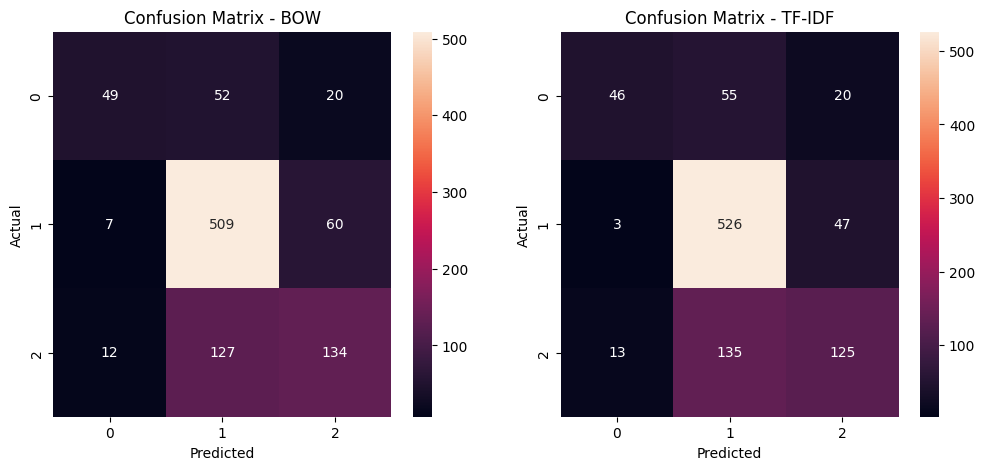

In [26]:
#  Compare results and show confusion matrices
# quick summary and confusion matrices to compare errors.

import matplotlib.pyplot as plt
import seaborn as sns

acc_bow = accuracy_score(y_test, y_pred_bow)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)

print("BOW accuracy:", acc_bow)
print("TF-IDF accuracy:", acc_tfidf)

# confusion matrices
cm_bow = confusion_matrix(y_test, y_pred_bow)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_bow, annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Confusion Matrix - BOW")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_tfidf, annot=True, fmt="d", ax=axes[1])
axes[1].set_title("Confusion Matrix - TF-IDF")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.show()


In [27]:
#  Save models and vectorizers for reproducibility
# saves files to the current working directory; download from Colab Files panel.

import joblib
joblib.dump(rf_bow, "rf_bow_model.joblib")
joblib.dump(bow_vectorizer, "bow_vectorizer.joblib")
joblib.dump(rf_tfidf, "rf_tfidf_model.joblib")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")
print("Saved models and vectorizers as joblib files.")


Saved models and vectorizers as joblib files.
